# Preface

This is the python code appendix (1/2) of the research paper "Social interactions in volatile markets - a GameStop story".

# Gather reddit data

Pushshift.io API created by the /r/datasets mod team to help provide enhanced functionality and search capabilities for searching Reddit comments and submissions. This RESTful API gives full functionality for searching Reddit data and also includes the capability of creating powerful data aggregations.
https://github.com/pushshift/api 

The code below kept generally to ensure an easy application for further research.
GME specific attributes are regonisable and marked as such.

Code for download the dataset is based on:
https://colab.research.google.com/drive/1biLcXeHs8yZD1x9f3gv-cNJXEq7tpyoO?usp=sharing#scrollTo=MBikywNJ8ufl

## Get submissions from subreddit

In [1]:
import pandas as pd  # Pandas for data frame adaptions
import requests      # Pushshift accesses Reddit via an url so this is needed
import json          # JSON manipulation to convert the data from URL
import csv           # To Convert final table into a csv file
import time
import datetime

The Pushshift API is accessible through building an URL with the relevant parameters.

In [2]:
#This function builds an Pushshift URL, accesses the webpage and stores JSON data in a nested list
def getPushshiftData(query, after, before, sub):

    #Build URL
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=10000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
        
    #Request URL
    r = requests.get(url)
    
    #Load JSON data from webpage into data variable
    data = json.loads(r.text)
    
    #return the data element which contains all the submissions data
    return data['data']

There are 2 different categories how a user can participate in a subreddit: Submitting a post or by commenting the postings of others. Since submissions are more significant contribution to the communities, the focus is on them.

<b>Parameters for the Pushshift URL include:</b>
- Size: increase limit of returned entries
- Subreddit: to narrow it down to a particular subreddit
- After: where to start the search
- Before: where to end the search

<b>Furthermore, there are also other parameters specific to submissions, we need to include: </b>
- Author: The reddit user name
- Sub_id: The unique identifier of the submission
- Score: The number of "Upvotes", a measurement on how well the community perceived the submission
- Title: The submission title
- Selftext: The submission text
- NumComms: The number of comments, a measurement on how engaging the community perceived the submission
- Flair: The category of the submission - user can choose from a predefined list.

In [3]:
#This function will be used to extract the key data points from each JSON result
def collectSubData(subm):
    #subData was created at the start to hold all the data which is then added to our global subStats dictionary.
    subData = list() #list to store data points
    title = subm['title']
    url = subm['url']
    #flairs are not always present so we wrap in try/except     
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"    
    author = subm['author']
    sub_id = subm['id']
    score = subm['score']    
    #Selftext is not always present, so we wrap in try/except
    try:
        selftext = subm['selftext'].replace('\r', '').replace('\n', '')
        # We replace certain symbols to disable line breaks
    except KeyError:
        selftext = "NaN"
    created = datetime.datetime.fromtimestamp(subm['created_utc']) #1520561700.0
    numComms = subm['num_comments']
    permalink = subm['permalink']


    #Put all data points into a tuple and append to subData
    subData.append((sub_id,title,url,author,score,created,numComms,permalink,flair,selftext))
    #Create a dictionary entry of current submission data and store all data related to it
    subStats[sub_id] = subData

Create timestamps and queries for search URL: https://timestampgenerator.com/

In [4]:
global after
global before
global query
global sub
global name

after = "1606694400"    # Submissions after this timestamp 
before = "1632960000"   # Submissions before this timestamp 
                        # 1606694400 = 2020-11-30
                        # 1632960000 = 2021-09-30
                        # 1606780800 = 01 Dec 2020 
                        # 1617062400 = 30 Mar 2021
                        # 1617148800 = 31 Mar 2021
                        # 1619690210 = 29 Apr 2021
                        # 1619740800 = 30 Apr 2021 (00:00)
                        # 1619823600 = 30 Apr 2021 (23:00)
                        # 1622505600 = 01 Jun 2021 (00:00)
                        
query = ""              # Keyword(s) to look for in submissions, "" means disabled
sub = "GME"             # Which Subreddit to search in
                        # amcstock
                        # GME
                        # superstonk
name = sub              # Name for the file(s) 

# https://api.pushshift.io/reddit/search/submission/?sub=GME&size=100&before=1617148800&after=1617062400

#subCount tracks the no. of total submissions we collect
subCount = 0
#subStats is the dictionary where we will store our data.
subStats = {}

In [ ]:
# We need to run this function outside the loop first to get the updated after variable
data = getPushshiftData(query, after, before, sub)

# Will run until all posts have been gathered i.e. When the length of data variable = 0
# from the 'after' date up until before date
while len(data) > 0: #The length of data is the number submissions (data[0], data[1] etc), once it hits zero (after and before vars are the same) end
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    print(len(data))
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    #update after variable to last created date of submission
    after = data[-1]['created_utc']
    #data has changed due to the new after variable provided by above code
    while True:
        try:
            data = getPushshiftData(query, after, before, sub)
            break
        except:
            pass
    
print(len(data))

# Some summary statistics from subStats
# print(str(len(subStats)) + " submissions have added to list")
# print("1st entry is:")
# print(list(subStats.values())[0][0][1] + " created: " + str(list(subStats.values())[0][0][5]))
# print("Last entry is:")
# print(list(subStats.values())[-1][0][1] + " created: " + str(list(subStats.values())[-1][0][5]))

Create the file from data function as .csv. To validate results, look into https://subredditstats.com/r/palantir to compare user activity.

In [6]:
def updateSubs_file():
    upload_count = 0
    #location = "\\Reddit Data\\" >> If you're running this outside of a notebook you'll need this to direct to a specific location
    
    global filename
    global file
    global name
    
    name = "GMEinitial"
    filename = "%s.csv" % name
    file = filename
    
    # filename = input() #This asks the user what to name the file
    with open(file, 'w', newline='', encoding='utf-8') as file: 
        a = csv.writer(file, delimiter='\t') # we need to take tabs, because submission texts contain ","
        headers = ["Post ID","Title","Url","Author","Score","Submission_Date","Total_Num_of_Comments","Permalink","Flair","Selftext"]
        a.writerow(headers)
        for sub in subStats:
            a.writerow(subStats[sub][0])
            upload_count+=1
            
        print(str(upload_count) + " submissions have been uploaded")
updateSubs_file()

203576 submissions have been uploaded


## Clean data - technically correct and consitent

In [121]:
global filename
global file
global name
    
name = "GME"
filename = "%s.csv" % name
file = filename

### Set variable types correctly

In [122]:
import pandas as pd
import seaborn as sns
from datetime import datetime

df = pd.read_csv(filename, delimiter='\t')
df['Submission_Date'] = pd.to_datetime(df['Submission_Date'], format='%Y-%m-%d %H:%M:%S')
# df['TitleAndText'] = df['Title'].str.cat(df['Selftext'],sep=" ")
df['TitleAndText'] = df['Title'] + " " + df['Selftext'] 
df['Word Count'] = df['TitleAndText'].str.count(' ') + 1
df.to_csv(filename, sep='\t', index=False)

### Clean up Flairs for Subreddit /r/gme

To merge categories and unify content

In [123]:
# Check flair column for unique values
df = pd.read_csv(filename, delimiter='\t')
df.groupby('Flair').count()
df.Flair.unique()

array([nan, 'D.D', 'Fluff', '💎🙌', 'News', 'Discussion',
       'Hedge Fund Tears', 'Memes', 'DD', 'Shitpost', 'YOLO', 'Charity',
       'Question', 'Mod Announcement', 'Shit Tier DD',
       'Shit Tier Question', 'Art',
       "COMPILATION OF ALL DUE DILLIGENCE / FAQ'S / ADDITIONAL RESOURCES",
       'Question 🙋\u200d♂️', 'Art and Media', 'Memes 🤣', 'r/GME Pets 🐱',
       'Mod Announcement 🦍', 'Hedge Fund Tears 😭', 'Shitpost 🎱', 'News 📰',
       'Discussion 🦍', 'Fluff 🍌', 'DD 📊', 'Opinion 👽', 'Art and Media 🎨',
       'YOLO 🙌', '🦍', 'Charity 🙌', 'Knowledge 🐒', 'HODL 💎🙌', 'YOLO 🤑',
       "🚀DUE DILIGENCE / FAQ'S / ADDITIONAL RESOURCES🚀", 'Knowledge',
       'r/GME Pets', 'Mod Announcement 🐒', 'Opinion', '💎 🙌',
       '☁️ Fluff  🍌', '🔬 DD 📊', 'r/GME Art', '💭 Opinion 💭',
       '🖥️ Terminal | Data 🖥👨\u200d💻', '📱 Social Media 🐦',
       '🐵 Discussion 💬', '🙋\u200d♀️ Question 🙋\u200d♂️', '📟 News 📰',
       'Memes 😹', '🙌🏻 Charity 😇', '🐶 r/GME Pets 🐱', 'Hedge Fund Tears 🏦😭',
       '😎 YOLO 🤑',

In [124]:
import pandas as pd
global filename
global file
global name
name = "GME"
filename = "%s.csv" % name
file = filename

df = pd.read_csv(filename, delimiter='\t')
df["Flair"].replace({"D.D": "Due Diligence", 
                     "🖥️ Terminal | Data 🖥👨‍💻": "Due Diligence",
                     "🖥️ Terminal | Data  👨\u200d💻": "Due Diligence",
                     "DD 📊": "Due Diligence",
                     "DD": "Due Diligence", 
                     "🔬 DD 📊": "Due Diligence", 
                     "Knowledge 🐒": "Due Diligence",
                     "🖥️ Terminal | Data 🖥️👨‍💻": "Due Diligence",
                     "🚀DUE DILIGENCE / FAQ'S / ADDITIONAL RESOURCES🚀": "Due Diligence",
                     
                     "Question 🙋‍": "Question",
                     "🙋‍♀️ Question 🙋": "Question",
                     "🙋‍♀️ Question 🙋‍♂️": "Question",
                     "Question 🙋‍♂️": "Question",
                     "Poll": "Question",
                     
                     "Art": "Art and Media", 
                     "r/GME Art 🖼️ 🎨🖌️": "Art and Media",
                     "Art and Media 🎨": "Art and Media",
                     "r/GME Pets 🐱": "Art and Media",
                     "r/GME Pets": "Art and Media",
                     "🐶 r/GME Pets 🐱": "Art and Media",
                     "Youtube/Videos": "Art and Media",
                     "🖼️ Art 🎨🖌️": "Art and Media",
                     "r/GME Art": "Art and Media",
                     
                     "Hedge Fund Tears 🏦😭": "Hedge Fund Tears", 
                     "Hedge Fund Tears 😭": "Hedge Fund Tears",
                     
                     "💎 🙌": "Diamond Hands", 
                     "💎🙌": "Diamond Hands",
                     "HODL 💎🙌": "Diamond Hands",
                     
                     "😎 YOLO 🤑": "YOLO",
                     "YOLO 🙌": "YOLO",
                     "YOLO 🤑": "YOLO",
                     
                     "Shit Tier DD": "Memes",
                     "😂 Memes 😹": "Memes", 
                     "Memes 🤣": "Memes",
                     "Memes 😹": "Memes",
                     
                     "☁️ Fluff  🍌": "Fluff", 
                     "Fluff 🍌": "Fluff",

                     "📰 News | Media 📱": "News",
                     "News 📰": "News",
                     "📟 News 📰": "News",
                     "📺 News 📰": "News",

                     "🐵 Discussion 💬": "Discussion",
                     "Discussion 🦍": "Discussion",
                     "💭 Opinion 💭": "Discussion",
                     "Opinion 👽": "Discussion",
                     "🚀 Megathread 🚀": "Discussion",
                     "Opinion": "Discussion",
                     
                     "🤡 Shitpost 🎱": "Provocative",
                     "Shitpost 🎱": "Provocative",
                     " :illuminati: DD :illuminati:": "Provocative",
                     "Shitpost": "Provocative",
                     "Shit Tier Question": "Provocative", 

                     "📱 Social Media 🐦": "Social Media",
                     "🙌🏻 Charity 😇": "Charity",
                     "Charity 🙌": "Charity",
                     "COMPILATION OF ALL DUE DILLIGENCE / FAQ'S / ADDITIONAL RESOURCES":"Mod Announcement",
                     "Mod Announcement 🦍": "Mod Announcement",
                     "Mod Announcement 🐒": "Mod Announcement",
                     "🦍 Mod Announcement 🦍": "Mod Announcement",
                     
                     "🦍":"meaningless",
                     "Baby 🐋":"meaningless",
                     "🦍 How To 🦍":"meaningless",
                     "🐍Debunked🐍":"meaningless",
                     "nan":"meaningless"
                    }, inplace=True)
df.to_csv('GME.csv', sep='\t', index=False)

# Check flair column for unique values
df = pd.read_csv(filename, delimiter='\t')
df.groupby('Flair').count()
df.Flair.unique()

array([nan, 'Due Diligence', 'Fluff', 'Diamond Hands', 'News',
       'Discussion', 'Hedge Fund Tears', 'Memes', 'Provocative', 'YOLO',
       'Charity', 'Question', 'Mod Announcement', 'Art and Media',
       'meaningless', 'Knowledge', 'Social Media'], dtype=object)

## Descriptive analysis

### Number of submissions in subreddit during time

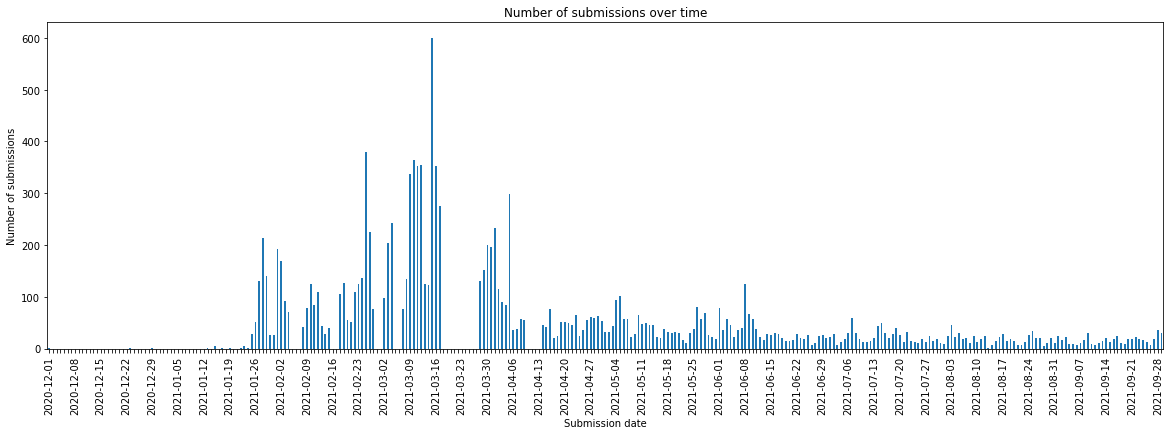

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
name = "GME"
filename = "%s.csv" % name
file = filename

df = pd.read_csv(filename, delimiter='\t', parse_dates=['Submission_Date'])
df['Submission_Date'] = pd.to_datetime(df['Submission_Date'], format='%Y-%m-%d %H:%M:%S')
df = df.groupby(pd.Grouper(key='Submission_Date',freq='H')).count()
df = df.rename(columns={"Post ID": "Number_of_Submissions"})
df = df.drop(columns=['Title', 'Url', 'Author', 'Score', 'Total_Num_of_Comments', 'Permalink', 'Flair', 'Selftext', 'TitleAndText', 'Word Count'])
df.to_csv('GME_Number_of_Submissions_per_hour.csv')
df.head()

# reindex to fill dates with no posts
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H')
df = df.reindex(pd.date_range(df.index.min(), df.index.max()))
df.index = df.index.strftime('%Y-%m-%d %H') 

df = df['Number_of_Submissions']
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H')
df = df.reindex(pd.date_range(df.index.min(), df.index.max()))
df.index = df.index.strftime('%Y-%m-%d')
 
ax = df.plot.bar(figsize=(20,6))
plt.xlabel('Submission date')
plt.ylabel('Number of submissions')
plt.title('Number of submissions over time')
every_nth = 7
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

### Ratio of flairs in subreddit over time

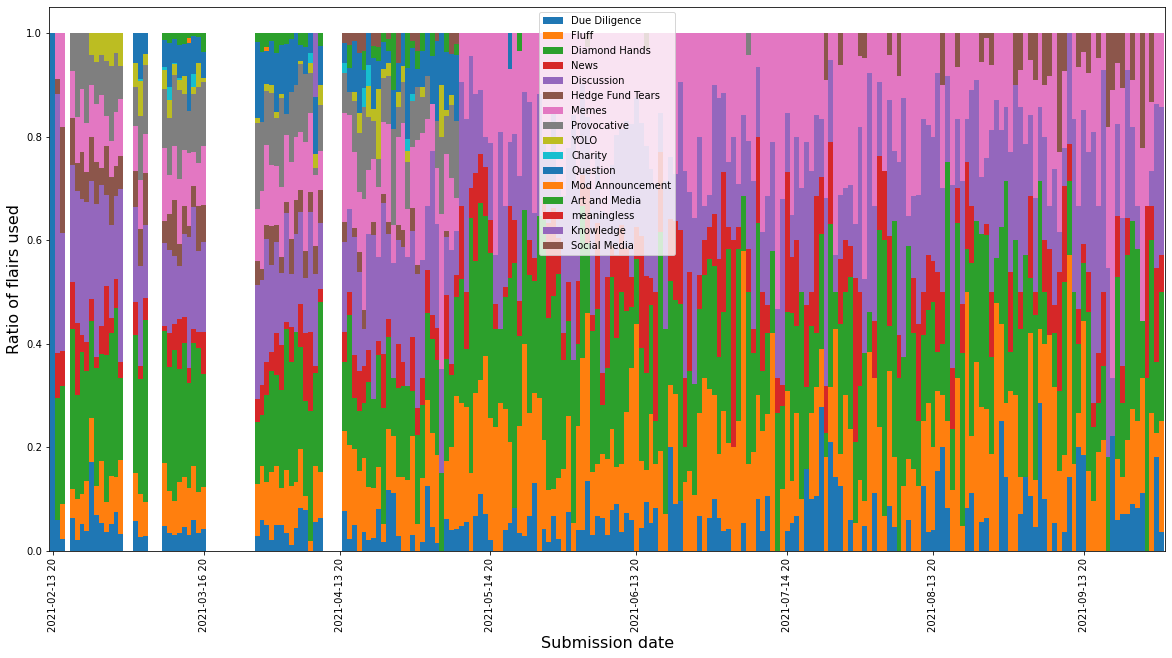

In [2]:
import os
import pandas as pd
from pandas import * 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import plotly.graph_objects as go

# os.chdir('E:\\Programmierung\\Jupyther Notebooks\\1. Create Reddit Submission Dataset\\')
name = "GME"
filename = "%s.csv" % name

df = pd.read_csv(filename, delimiter='\t')

df['Submission_Date'] = pd.to_datetime(df['Submission_Date'], format = "%Y-%m-%d %H:%M:%S").dt.strftime('%Y-%m-%d %H')
df['Submission_Date'] = pd.to_datetime(df['Submission_Date'])
# display(df)
# df = df.dropna()
df = df[df['Flair'].notna()]

# df.replace(r'^\s*$', np.nan, regex=True)

unique_flairs = list(df['Flair'].unique())
flair_df = pd.DataFrame()
df.groupby(['Submission_Date', 'Flair']).size()

# iterate over unique dates
for date in df['Submission_Date'].unique():
    date_subset = df.loc[df['Submission_Date'] == date]
    # for flairs in each date, get counts of values
    counts = date_subset['Flair'].value_counts()
    # get shares
    shares = counts / len(date_subset)
    # transpose series for appending
    shares_df = pd.DataFrame(shares).transpose()
    shares_df['Submission_Date'] = date
    for flair in [x for x in unique_flairs if x not in shares_df.columns]:
        shares_df[flair] = np.nan
    # append shares per date
    flair_df = pd.concat([flair_df, shares_df])
    flair_df = flair_df.reset_index(drop=True)  
    
# rearrange columns and save dataframe
flair_df = flair_df[['Submission_Date'] + unique_flairs]
flair_df.index = pd.to_datetime(flair_df.index, format='%Y-%m-%d %H')
flair_df.set_index('Submission_Date', inplace=True)
# flair_df.head()
flair_df.to_csv('GME_FLAIRS_per_hour.csv')

# reindex to fill dates with no posts
flair_df.index = pd.to_datetime(flair_df.index, format='%Y-%m-%d %H')
flair_df = flair_df.reindex(pd.date_range(flair_df.index.min(), flair_df.index.max()))
flair_df.index = flair_df.index.strftime('%Y-%m-%d %H')

# Plot
fig, ax = plt.subplots(figsize=(20,10))
flair_df.plot(kind='bar',ax=ax, stacked=True, width=1)
plt.xlabel('Submission date', fontsize=16)
plt.ylabel('Ratio of flairs used', fontsize=16)
ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# print(df.groupby(['Submission_Date', 'Flair']).size())

******************

# Analysis

## Merge data frames

Pricing data (several jupyther notebook) is needed

(18673.0, 18747.0)

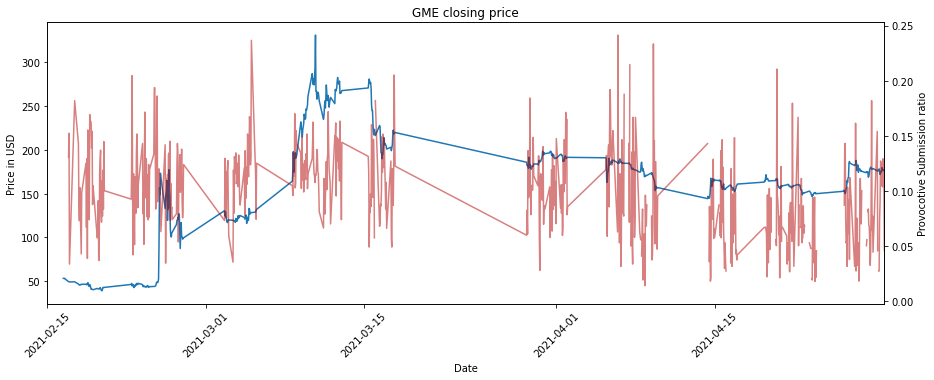

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Get Flairs
df1 = pd.read_csv('GME_FLAIRS_per_hour.csv', sep=',')
df1['time'] = pd.to_datetime(df1['Submission_Date'])
df1['time'] = df1['time'].dt.round('60min')
df1.set_index('time', inplace=True)
df1 = df1.drop('Submission_Date', 1)
df1.sort_index()
df1



# Get stock data
df2 = pd.read_csv('stockdata_UTC_final.csv', sep=',')
df2

df2['time'] = pd.to_datetime(df2['time'])
df2['time']= df2['time'].dt.round('60min')
df2.set_index('time', inplace=True)
df2.sort_index()
df2

# Merge Flairs per hour with stock data
result = pd.merge(df1,df2, how='inner', left_index=True, right_index=True)
result.head()

# Get number of submissions
df3 = pd.read_csv('GME_Number_of_Submissions_per_hour.csv', sep=',')
df3['time'] = pd.to_datetime(df3['Submission_Date'])
df3.set_index('time', inplace=True)
df3 = df3.drop(columns=['Submission_Date'])
df3.sort_index()
df3


# Merge
df4 = pd.merge(result,df3, how='inner', left_index=True, right_index=True)
# Save merged dataframe
df4.to_csv('results.csv')
df4

# plot
result.sort_index()
flair = result['Provocative']

fig = plt.figure(figsize=(15, 7))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(result['close'], label='close')
plt.title('GME closing price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30)) 
plt.gca().xaxis.set_tick_params(rotation = 45)

axis_2 = top.twinx()
axis_2.set_ylabel('Provocotive Submission ratio')
axis_2.plot(flair, color='#b30000', alpha=0.5)

axis_2.set_xlim(left=pd.Timestamp("2021-02-15"), right=pd.Timestamp("2021-04-30 00:00:00"))

# plt.show()

# Flairs to plot from (1) Create Reddit Submission Dataset
# array([nan, 'Due Diligence', 'Fluff', 'Diamond Hands', 'News',
#       'Discussion', 'Hedge Fund Tears', 'Memes', 'Shitpost', 'YOLO',
#       'Charity', 'Question', 'Mod Announcement', 'Art and Media',
#       'Knowledge', 'Opinion', 'Social Media']

# Preparation for time series

To include time dimension in the correlation analysis, it is necessary to prepare the dataframe accordingly. This means, adding new variables for the time dimension, derived from the index of the dataframe.

In [4]:
import pandas as pd
# Convert Index to time
df4 = pd.read_csv('results.csv', sep=',')
df4.set_index('time', inplace=True)
df4.reset_index(level=['time'])
df4['Time'] = df4.index

df4['Month'] = pd.DatetimeIndex(df4['Time']).month
df4['Quarter'] = pd.DatetimeIndex(df4['Time']).quarter

# Rearrange columns
col_name="Number_of_Submissions"
first_col = df4.pop(col_name)
df4.insert(0, col_name, first_col)
col_name="returns"
first_col = df4.pop(col_name)
df4.insert(0, col_name, first_col)
df4.to_csv('df4.csv')
df4

,returns,Number_of_Submissions,Due Diligence,Fluff,Diamond Hands,News,Discussion,Hedge Fund Tears,Memes,Provocative,...,Knowledge,Social Media,open,high,low,close,volume,Time,Month,Quarter
time,,,,,,,,,,,,,,,,,,,,,
2021-02-16 10:00:00,0.005671,24,0.166667,0.083333,0.458333,0.041667,0.166667,0.041667,0.041667,NaN,...,NaN,NaN,53.0200,53.60,52.92,53.2000,10059,2021-02-16 10:00:00,2,1
2021-02-16 11:00:00,0.000188,18,0.294118,0.058824,0.235294,0.058824,0.294118,NaN,0.058824,NaN,...,NaN,NaN,53.1100,54.01,53.11,53.2100,8664,2021-02-16 11:00:00,2,1
2021-02-16 12:00:00,-0.003759,20,0.315789,NaN,0.105263,0.052632,0.473684,0.052632,NaN,NaN,...,NaN,NaN,53.2100,54.20,53.00,53.0100,11754,2021-02-16 12:00:00,2,1
2021-02-16 13:00:00,0.004339,26,0.160000,0.160000,0.440000,NaN,0.120000,0.040000,0.080000,NaN,...,NaN,NaN,53.0600,53.60,52.40,53.2400,56140,2021-02-16 13:00:00,2,1
2021-02-16 14:00:00,-0.015778,20,NaN,0.050000,0.500000,0.100000,0.150000,NaN,0.200000,NaN,...,NaN,NaN,52.6784,53.45,52.00,52.4000,94780,2021-02-16 14:00:00,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-29 19:00:00,0.003855,16,NaN,0.312500,0.062500,0.250000,0.312500,NaN,0.062500,NaN,...,NaN,NaN,176.4200,177.89,176.00,177.0499,178917,2021-09-29 19:00:00,9,3
2021-09-29 20:00:00,-0.004857,28,0.035714,0.214286,0.250000,0.071429,0.285714,NaN,0.142857,NaN,...,NaN,NaN,177.1500,178.13,175.49,176.1900,272780,2021-09-29 20:00:00,9,3
2021-09-29 21:00:00,0.010273,21,0.047619,0.095238,0.238095,0.047619,0.285714,NaN,0.285714,NaN,...,NaN,NaN,175.9200,179.05,175.92,178.0000,11730,2021-09-29 21:00:00,9,3


# Pearson correlation

## For the complete dataframe

In [1]:
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# leave out following flairs
df4 = pd.read_csv('df4.csv', sep=',')
df5 = df4.drop(columns=['meaningless', 'Time', 'Knowledge', 'open', 'high', 'close', 'low', 'Month', 'Quarter'])
#df5 = df5.fillna(0)
df5 = df5.fillna(df5.mean())
df5.head()
 
rho = df5.corr()
pval = df5.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho = rho.round(2).astype(str) + p
rho

,returns,Number_of_Submissions,Due Diligence,Fluff,Diamond Hands,News,Discussion,Hedge Fund Tears,Memes,Provocative,YOLO,Charity,Question,Mod Announcement,Art and Media,Social Media,volume
returns,1.0***,0.12***,-0.04*,-0.02,0.05**,-0.02,-0.03,0.05**,-0.03,0.01,-0.01,0.03,0.0,-0.01,-0.01,0.0,0.27***
Number_of_Submissions,0.12***,1.0***,-0.31***,-0.27***,0.07***,-0.24***,-0.14***,0.27***,-0.29***,0.26***,-0.04*,-0.28***,-0.19***,-0.07***,-0.28***,-0.05***,0.66***
Due Diligence,-0.04*,-0.31***,1.0***,0.1***,-0.12***,0.16***,0.07***,-0.01,0.1***,-0.05**,0.03,0.06***,0.04**,-0.0,0.06***,0.06***,-0.21***
Fluff,-0.02,-0.27***,0.1***,1.0***,-0.07***,0.08***,-0.05**,-0.04**,0.09***,-0.03,-0.02,0.02,0.01,-0.0,0.01,0.11***,-0.16***
Diamond Hands,0.05**,0.07***,-0.12***,-0.07***,1.0***,-0.1***,-0.19***,0.09***,-0.13***,0.02,0.01,-0.08***,-0.08***,0.01,-0.07***,0.01,0.14***
News,-0.02,-0.24***,0.16***,0.08***,-0.1***,1.0***,-0.03,-0.02,0.05**,-0.07***,-0.02,0.04*,0.02,0.01,0.04**,0.1***,-0.16***
Discussion,-0.03,-0.14***,0.07***,-0.05**,-0.19***,-0.03,1.0***,-0.05**,-0.12***,-0.04*,-0.01,0.04*,-0.01,-0.0,0.0,0.04**,-0.12***
Hedge Fund Tears,0.05**,0.27***,-0.01,-0.04**,0.09***,-0.02,-0.05**,1.0***,-0.05**,0.19***,0.18***,-0.15***,-0.07***,-0.03,-0.0,0.1***,0.3***
Memes,-0.03,-0.29***,0.1***,0.09***,-0.13***,0.05**,-0.12***,-0.05**,1.0***,-0.06***,0.01,0.03,-0.0,0.01,0.02,0.04**,-0.17***
Provocative,0.01,0.26***,-0.05**,-0.03,0.02,-0.07***,-0.04*,0.19***,-0.06***,1.0***,-0.01,-0.15***,-0.14***,-0.1***,-0.14***,0.08***,0.16***


## For quarters

In [ ]:
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# leave out following flairs
df4 = pd.read_csv('df4.csv', sep=',')
df5 = df4.drop(columns=['meaningless', 'Time', 'Knowledge', 'open', 'high', 'close', 'low', 'Month'])
#df5 = df5.fillna(0)
df5 = df5.fillna(df5.mean())
df5.head()

grouped = df5.groupby('Quarter', group_keys=False, as_index=False)
# grouped = df5.groupby('Month', group_keys=False, as_index=False)

for name, group in grouped:
    print("Quarter: ",name)
    # print(group)
    rho = group.corr()
    pval = group.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
    rho = rho.round(2).astype(str) + p
    display(rho)

## For months

In [ ]:
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# leave out following flairs
df4 = pd.read_csv('df4.csv', sep=',')

df4 = df4.drop(columns=['meaningless', 'Time', 'Knowledge', 'open', 'high', 'close', 'low', 'Quarter'])
#df4 = df4.fillna(0)
df4 = df4.fillna(df5.median())

# grouped = df4.groupby('Quarter', group_keys=False, as_index=False)
grouped = df4.groupby('Month', group_keys=False, as_index=False)

for name, group in grouped:
    print("Month: ",name)
    # print(group)
    rho = group.corr()
    pval = group.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
    rho = rho.round(2).astype(str) + p
    display(rho)

## For highly volatile events (days/hours)

Frist: add an event marker, when stock performed +/-x% in one hour

Second: calculate correlation

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
df4 = pd.read_csv('results.csv', sep=',')

# df4.set_index('time', inplace=True)
def categorise(row):  
    if row['returns'] <= 0.05 and row['returns'] >= 0.01:
    # 0.05 = 5%
    # 0.1 = 10%
    # if row['returns'] >= 0.01:
    # if row['returns'] <= -0.01:
    # if row['returns'] >= 0.01 or row['returns'] <= -0.01:
        return 'True'
df4['Volatile_Hour'] = df4.apply(lambda row: categorise(row), axis=1)

# Rearrange Columns
shiftPos = df4.pop("Number_of_Submissions")
df4.insert(0, "Number_of_Submissions", shiftPos)
shiftPos = df4.pop("returns")
df4.insert(0, "returns", shiftPos)


# leave out following flairs
df4 = df4.drop(columns=['meaningless', 'Knowledge', 'open', 'high', 'close', 'low', 'time'])

df4 = df4.loc[df4['Volatile_Hour'] == 'True']
print(df4['Volatile_Hour'].value_counts())

#df4['Volatile_Hour'].value_counts()
df4['Volatile_Hour'] = np.where(df4['Volatile_Hour'] == 'True', 1, df4['Volatile_Hour'])
#df4 = df4.fillna(df4.median())
df4 = df4.fillna(0)

grouped = df4.groupby('Volatile_Hour', group_keys=False, as_index=False)
for name, group in grouped:
    print("Conditional hours")
    # print(group)
    rho = group.corr()
    pval = group.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
    rho = rho.round(2).astype(str) + p
    display(rho)

True    389
Name: Volatile_Hour, dtype: int64
Conditional hours


,returns,Number_of_Submissions,Due Diligence,Fluff,Diamond Hands,News,Discussion,Hedge Fund Tears,Memes,Provocative,YOLO,Charity,Question,Mod Announcement,Art and Media,Social Media,volume,Volatile_Hour
returns,1.0***,0.23***,-0.05,-0.07,0.16***,-0.08,-0.06,0.22***,-0.0,0.12**,0.09*,0.1*,-0.07,-0.04,-0.05,-0.12**,0.36***,nan
Number_of_Submissions,0.23***,1.0***,-0.13**,-0.27***,0.08,-0.18***,-0.15***,0.69***,-0.27***,0.7***,0.48***,0.33***,0.36***,0.1*,0.24***,-0.17***,0.68***,nan
Due Diligence,-0.05,-0.13**,1.0***,-0.16***,-0.17***,-0.07,-0.03,-0.08*,-0.01,-0.08,0.0,0.0,0.01,-0.01,-0.02,-0.05,-0.12**,nan
Fluff,-0.07,-0.27***,-0.16***,1.0***,-0.17***,0.05,-0.17***,-0.36***,-0.09*,-0.39***,-0.3***,-0.14***,-0.28***,-0.04,-0.17***,0.13**,-0.11**,nan
Diamond Hands,0.16***,0.08,-0.17***,-0.17***,1.0***,-0.25***,-0.21***,-0.01,-0.09*,-0.06,-0.06,0.01,-0.14***,-0.05,-0.13**,-0.22***,0.15***,nan
News,-0.08,-0.18***,-0.07,0.05,-0.25***,1.0***,-0.14***,-0.22***,-0.18***,-0.22***,-0.18***,-0.13***,-0.17***,-0.02,-0.16***,0.04,-0.13**,nan
Discussion,-0.06,-0.15***,-0.03,-0.17***,-0.21***,-0.14***,1.0***,-0.02,-0.27***,-0.04,-0.01,-0.08,-0.17***,0.03,-0.1**,-0.01,-0.12**,nan
Hedge Fund Tears,0.22***,0.69***,-0.08*,-0.36***,-0.01,-0.22***,-0.02,1.0***,-0.37***,0.81***,0.55***,0.33***,0.37***,0.03,0.31***,-0.16***,0.41***,nan
Memes,-0.0,-0.27***,-0.01,-0.09*,-0.09*,-0.18***,-0.27***,-0.37***,1.0***,-0.39***,-0.28***,-0.14***,-0.24***,-0.03,-0.16***,-0.05,-0.13***,nan
Provocative,0.12**,0.7***,-0.08,-0.39***,-0.06,-0.22***,-0.04,0.81***,-0.39***,1.0***,0.61***,0.36***,0.51***,0.13***,0.4***,-0.16***,0.36***,nan


# Additional Analysis

## Scatter Plot

Text(0, 0.5, 'Hourly returns of GME')

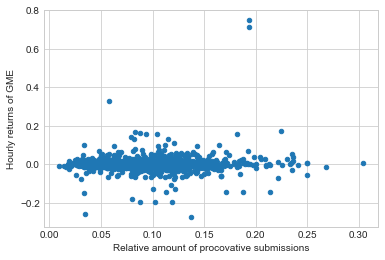

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
df4 = pd.read_csv('df4.csv', sep=',')
df4.plot(kind='scatter', x='Provocative', y='daily_returns')
plt.xlabel('Relative amount of procovative submissions')
plt.ylabel('Hourly returns of GME')

## Augmented Dickey-Fuller Test

In [22]:
# pip install statsmodels
# if p-value is not less than .05, we fail to reject the null hypothesis. 
# This indicates that the time series isn't stationary.

In [27]:
from statsmodels.tsa.stattools import adfuller
#perform augmented Dickey-Fuller test
df4 = pd.read_csv('df4.csv', sep=',')
df4 = df4[df4['daily_returns'].notna()]
adfuller(df4['daily_returns'])

(-10.908443125340979,
 1.112645598949103e-19,
 29,
 3624,
 {'1%': -3.432155722391455,
  '5%': -2.8623378673761084,
  '10%': -2.567194717193812},
 -15504.349200426608)